# Canadian Housing Market Forecasting: Time Series Analysis & Modelling.
Description:  

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Data Ingestion and Data Cleaning
Description: 

In [2]:
#csv for mortgage rates chartered_bank_interest.csv
#ingest the csv 
#take all dates after 1975-01-01
#take only the column named 5-year Conventional mortgage
df_chartered_bank_i = pd.read_csv('../Resources/Datasets/chartered_bank_interest.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df_chartered_bank_i.head()

,Prime rate,1-year Conventional mortgage,3-year Conventional mortgage,5-year Conventional mortgage,1-year GIC,3-year GIC,5-year GIC,5-year personal fixed term,"Daily Interest Savings (balances over $100,000)",Non-Chequable Savings Deposits
date,,,,,,,,,,
1967-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1967-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1967-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1967-04-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5
1967-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5


In [3]:
# Convert daily data to monthly through the resample function
df_chartered_bank_i.index = pd.to_datetime(df_chartered_bank_i.index)
df_chartered_bank_i_cleaned = df_chartered_bank_i.resample('1Q').mean()
df_chartered_bank_i_cleaned.tail()

,Prime rate,1-year Conventional mortgage,3-year Conventional mortgage,5-year Conventional mortgage,1-year GIC,3-year GIC,5-year GIC,5-year personal fixed term,"Daily Interest Savings (balances over $100,000)",Non-Chequable Savings Deposits
date,,,,,,,,,,
2020-12-31,2.45,3.090000,3.556154,4.79,0.350000,0.600000,0.857692,0.700000,0.01,0.01
2021-03-31,2.45,2.813077,3.490000,4.79,0.315385,0.530769,0.853846,0.700000,0.01,0.01
2021-06-30,2.45,2.790000,3.490000,4.79,0.250000,0.553846,1.003846,0.700000,0.01,0.01
2021-09-30,2.45,2.790000,3.490000,4.79,0.250000,0.600000,1.000000,0.700000,0.01,0.01
2021-12-31,2.45,2.790000,3.490000,4.79,0.261111,0.616667,1.020000,0.764444,0.01,0.01


In [4]:
df_chartered_bank_i_cleaned.drop(df_chartered_bank_i_cleaned.columns.difference(['5-year Conventional mortgage']), 1, inplace=True)
df_chartered_bank_i_cleaned.head()

,5-year Conventional mortgage
date,
1967-06-30,NaN
1967-09-30,NaN
1967-12-31,NaN
1968-03-31,NaN
1968-06-30,NaN


In [5]:
# Data ingestion - reading the CSV in from Statistics Canada and the Bank of Canada
# Credit liabilities of households.csv
# Residential mortgages 9+
df_Residential_mortgages = pd.read_csv('../Resources/Datasets/Credit liabilities of households.csv')
df_Residential_mortgages.head()

,Date,1/1/1990,2/1/1990,3/1/1990,4/1/1990,5/1/1990,6/1/1990,7/1/1990,8/1/1990,9/1/1990,...,12/1/2020,1/1/2021,2/1/2021,3/1/2021,4/1/2021,5/1/2021,6/1/2021,7/1/2021,8/1/2021,9/1/2021
0,Non-mortgage loans,121607,121404,122358,122922,123435,124132,124492,124806,125752,...,787490,780670,779984,779926,783466,787770,792582,793265,798152,802793
1,Chartered banks 1,77976,77819,78386,78566,78941,79564,80005,80526,81519,...,575885,571698,572927,575120,578333,581681,586632,587778,591617,595916
2,Personal loans 1 2,31781,31769,31878,32099,32316,32539,32687,32805,32854,...,113070,115030,115131,114723,115259,115462,116026,116245,116837,117381
3,Of which: Auto loans 1 2,0,0,0,0,0,0,0,0,0,...,90763,90156,89902,90276,90681,90911,91542,91917,92298,92252
4,Credit cards 1 2,9090,8768,8728,8883,9050,9232,9310,9516,9788,...,78388,73786,73374,74232,74249,75221,76422,77223,78335,79324


In [6]:
# Transpose 
res_mortgage_transp = df_Residential_mortgages.T
res_mortgage_transp.tail()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
5/1/2021,787770,581681,115462,90911,75221,318851,62921,30930,41217,206089,...,1979730,1706049,1297499,408550,9831,2998,6833,263850,255930,7920
6/1/2021,792582,586632,116026,91542,76422,320569,62921,31755,41860,205950,...,2005633,1730211,1316993,413218,9930,3048,6882,265492,257648,7844
7/1/2021,793265,587778,116245,91917,77223,321720,62908,30647,41943,205487,...,2022115,1745650,1331064,414586,9866,2979,6887,266599,258812,7787
8/1/2021,798152,591617,116837,92298,78335,323665,63073,30564,42216,206535,...,2038954,1760664,1344247,416417,9848,2949,6899,268442,260592,7850
9/1/2021,802793,595916,117381,92252,79324,325793,63514,30895,42523,206877,...,2052272,1772201,1354213,417988,9883,2953,6930,270188,262279,7909


In [7]:
# Remove unwanted columns
res_mortgage_transp = res_mortgage_transp.truncate(before='35', after='35', axis=1)
res_mortgage_transp.tail()

,35
5/1/2021,1706049
6/1/2021,1730211
7/1/2021,1745650
8/1/2021,1760664
9/1/2021,1772201


In [8]:
# Reset index and change headers
res_mortgage_transp = res_mortgage_transp.reset_index(drop=False)
new_header = res_mortgage_transp.iloc[0] #grab the first row for the header
res_mortgage_transp = res_mortgage_transp[1:] #take the data less the header row
res_mortgage_transp.columns = new_header #set the header row as the dataframe header
res_mortgage_transp.tail()

,Date,Residential mortgages 14
377,5/1/2021,1706049
378,6/1/2021,1730211
379,7/1/2021,1745650
380,8/1/2021,1760664
381,9/1/2021,1772201


In [9]:
# Rename the columns
res_mortgage_transp = res_mortgage_transp.rename(columns={'Residential mortgages 14': 'Residential Mortgages'})

In [10]:
# Review data types
res_mortgage_transp.dtypes

0
Date                     object
Residential Mortgages    object
dtype: object

In [11]:
res_mortgage_transp.tail()

,Date,Residential Mortgages
377,5/1/2021,1706049
378,6/1/2021,1730211
379,7/1/2021,1745650
380,8/1/2021,1760664
381,9/1/2021,1772201


In [12]:
# Convert data types to required format
res_mortgage_transp['Date'] = res_mortgage_transp['Date'].astype('datetime64[ns]')
res_mortgage_transp['Residential Mortgages'] = res_mortgage_transp['Residential Mortgages'].astype(float)
res_mortgage_transp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 1 to 381
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   381 non-null    datetime64[ns]
 1   Residential Mortgages  381 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.1 KB


In [13]:
res_mortgage_transp.tail()

,Date,Residential Mortgages
377,2021-05-01,1706049.0
378,2021-06-01,1730211.0
379,2021-07-01,1745650.0
380,2021-08-01,1760664.0
381,2021-09-01,1772201.0


In [14]:
# Convert monthly data to quarterly 
res_mortgage_transp.Date = pd.to_datetime(res_mortgage_transp.Date)

#setting the index to the Date column 
res_mortgage_transp.set_index('Date', inplace=True)
res_mortgage_transp.tail()


,Residential Mortgages
Date,
2021-05-01,1706049.0
2021-06-01,1730211.0
2021-07-01,1745650.0
2021-08-01,1760664.0
2021-09-01,1772201.0


In [15]:
#using resample to take Quarterly data 
res_mortgage_cleaned = res_mortgage_transp.resample('1Q').mean()

In [16]:
# Combined dataframe = 1 + 2 + 3 
res_mortgage_cleaned.tail()

,Residential Mortgages
Date,
2020-09-30,1.604927e+06
2020-12-31,1.639785e+06
2021-03-31,1.661492e+06
2021-06-30,1.708387e+06
2021-09-30,1.759505e+06


In [17]:
res_mortgage_cleaned['Residential Mortgages']=res_mortgage_cleaned['Residential Mortgages'].apply(lambda x:round(x,2))
res_mortgage_cleaned.tail()

,Residential Mortgages
Date,
2020-09-30,1604927.33
2020-12-31,1639785.00
2021-03-31,1661491.67
2021-06-30,1708387.33
2021-09-30,1759505.00


In [18]:
#take the csv in 
#extract this column name: Credit liabilities of households 1 2 3
#extract this column name: Residential mortgages 9 
#flip the row into a column (transpose method)
#since the dates won't match, we need to add null values

In [19]:
# House afforability index 
df_House_afford_index  = pd.read_csv('../Resources/Datasets/AffordabilityIndex date.csv')
df_House_afford_index.head()

,Date,New housing price index,Housing Affordability Index
0,1980-09-1,NaN,0.420
1,1980-12-1,NaN,0.461
2,1981-03-1,NaN,0.482
3,1981-06-1,NaN,0.534
4,1981-09-1,NaN,0.626


In [20]:
#here we will be doing some cleaning from this dataset and taking only the Housing Affordability Index
df_House_afford_index = df_House_afford_index.drop(columns=['New housing price index'])
df_House_afford_index.tail()

,Date,Housing Affordability Index
160,2020-09-1,0.315
161,2020-12-1,0.337
162,2021-03-1,0.347
163,2021-06-1,0.363
164,2021-09-1,NaN


In [21]:
df_House_afford_index.tail()

,Date,Housing Affordability Index
160,2020-09-1,0.315
161,2020-12-1,0.337
162,2021-03-1,0.347
163,2021-06-1,0.363
164,2021-09-1,NaN


In [22]:
# Review data types
df_House_afford_index.dtypes

Date                            object
Housing Affordability Index    float64
dtype: object

In [23]:
df_House_afford_index['Date'] = df_House_afford_index['Date'].astype('datetime64[ns]')
df_House_afford_index.dtypes


Date                           datetime64[ns]
Housing Affordability Index           float64
dtype: object

In [24]:
df_House_afford_index.set_index('Date', inplace=True)
df_House_afford_index_cleaned = df_House_afford_index.resample('1Q').last()

In [25]:
df_House_afford_index_cleaned.head()

,Housing Affordability Index
Date,
1980-09-30,0.420
1980-12-31,0.461
1981-03-31,0.482
1981-06-30,0.534
1981-09-30,0.626


In [26]:
#check null values 
res_mortgage_cleaned.isnull().sum()
#drop null values 




0
Residential Mortgages    0
dtype: int64

In [27]:
#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

#removing null values 
df_House_afford_index_cleaned = df_House_afford_index_cleaned.dropna().copy()

#check again for null values 
df_House_afford_index_cleaned.isnull().sum()

Housing Affordability Index    0
dtype: int64

In [28]:
df_House_afford_index_cleaned.tail()

,Housing Affordability Index
Date,
2020-06-30,0.300
2020-09-30,0.315
2020-12-31,0.337
2021-03-31,0.347
2021-06-30,0.363


In [29]:
#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()



5-year Conventional mortgage    31
dtype: int64

In [30]:
#removing null values 
df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned.dropna().copy()

#check again for null values 
df_chartered_bank_i_cleaned.isnull().sum()

5-year Conventional mortgage    0
dtype: int64

In [31]:
print(df_chartered_bank_i_cleaned.head())
print(df_chartered_bank_i_cleaned.tail())

            5-year Conventional mortgage
date                                    
1975-03-31                     11.250000
1975-06-30                     10.807692
1975-09-30                     11.403846
1975-12-31                     12.000000
1976-03-31                     11.846154
            5-year Conventional mortgage
date                                    
2020-12-31                          4.79
2021-03-31                          4.79
2021-06-30                          4.79
2021-09-30                          4.79
2021-12-31                          4.79


In [32]:
#slice only the dates from 1990-03-31 TO 2021-06-30

df_chartered_bank_i_cleaned = df_chartered_bank_i_cleaned['1990-03-31' :'2021-06-30']
print(df_chartered_bank_i_cleaned.head())
print(df_chartered_bank_i_cleaned.tail())

            5-year Conventional mortgage
date                                    
1990-03-31                     12.423077
1990-06-30                     14.096154
1990-09-30                     13.769231
1990-12-31                     12.980769
1991-03-31                     11.865385
            5-year Conventional mortgage
date                                    
2020-06-30                      4.993846
2020-09-30                      4.854286
2020-12-31                      4.790000
2021-03-31                      4.790000
2021-06-30                      4.790000


In [33]:
# for Housing Affordability Index
#slice only the dates from 1990-03-31 TO 2021-06-30

df_House_afford_index_cleaned = df_House_afford_index_cleaned['1990-03-31' :'2021-06-30']
print(df_House_afford_index_cleaned.head())
print(df_House_afford_index_cleaned.tail())



            Housing Affordability Index
Date                                   
1990-03-31                        0.479
1990-06-30                        0.527
1990-09-30                        0.494
1990-12-31                        0.467
1991-03-31                        0.434
            Housing Affordability Index
Date                                   
2020-06-30                        0.300
2020-09-30                        0.315
2020-12-31                        0.337
2021-03-31                        0.347
2021-06-30                        0.363


In [34]:
# for Residential Mortgages
#we slice only the dates from 1990-03-31 TO 2021-06-30

res_mortgage_cleaned = res_mortgage_cleaned['1990-03-31' :'2021-06-30']
print(res_mortgage_cleaned.head())
print(res_mortgage_cleaned.tail())



0           Residential Mortgages
Date                             
1990-03-31              229940.67
1990-06-30              236727.00
1990-09-30              242165.67
1990-12-31              246922.00
1991-03-31              250729.33
0           Residential Mortgages
Date                             
2020-06-30             1575288.33
2020-09-30             1604927.33
2020-12-31             1639785.00
2021-03-31             1661491.67
2021-06-30             1708387.33


In [35]:
res_mortgage_cleaned.tail()

,Residential Mortgages
Date,
2020-06-30,1575288.33
2020-09-30,1604927.33
2020-12-31,1639785.00
2021-03-31,1661491.67
2021-06-30,1708387.33


In [38]:
#combine into a single dataframe
 
housing_analysis_combined_df = pd.concat([res_mortgage_cleaned, df_House_afford_index_cleaned, df_chartered_bank_i_cleaned], axis="columns", join="inner")

# Sort datetime index in ascending order (past to present)
housing_analysis_combined_df.sort_index(inplace=True)

# Display a few rows
housing_analysis_combined_df.head()


,Residential Mortgages,Housing Affordability Index,5-year Conventional mortgage
1990-03-31,229940.67,0.479,12.423077
1990-06-30,236727.00,0.527,14.096154
1990-09-30,242165.67,0.494,13.769231
1990-12-31,246922.00,0.467,12.980769
1991-03-31,250729.33,0.434,11.865385


In [40]:
#Now we have a combined dataframe with all the feature variables 
housing_analysis_combined_df.tail()

,Residential Mortgages,Housing Affordability Index,5-year Conventional mortgage
2020-06-30,1575288.33,0.300,4.993846
2020-09-30,1604927.33,0.315,4.854286
2020-12-31,1639785.00,0.337,4.790000
2021-03-31,1661491.67,0.347,4.790000
2021-06-30,1708387.33,0.363,4.790000


<AxesSubplot:>

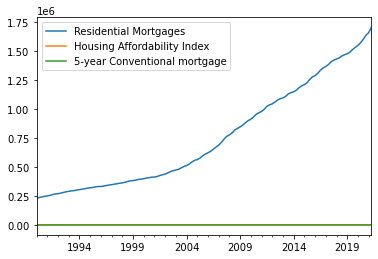

In [41]:
housing_analysis_combined_df.plot()

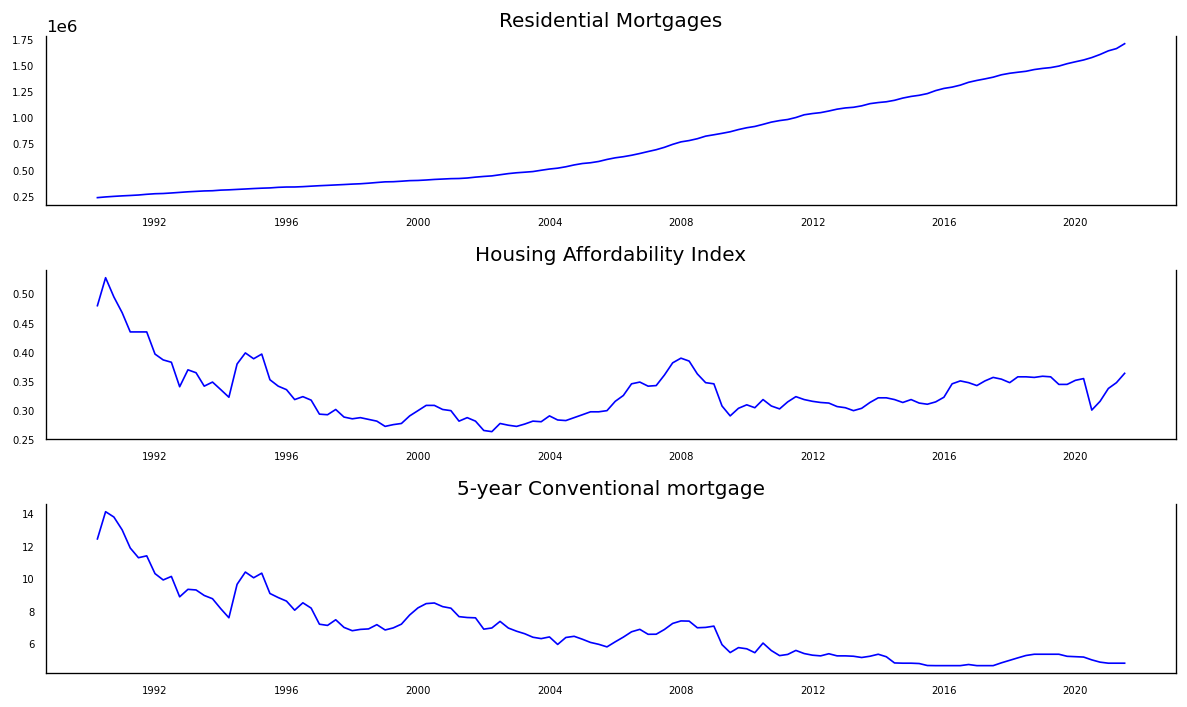

In [46]:
# Plot
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = housing_analysis_combined_df[housing_analysis_combined_df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(housing_analysis_combined_df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [ ]:
#Next steps: 

#Testing Causation using Granger’s Causality Test

In [49]:
from statsmodels.tsa.stattools import grangercausalitytests


In [57]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

df_grangers = grangers_causation_matrix(housing_analysis_combined_df, variables = housing_analysis_combined_df.columns) 
df_grangers

,Residential Mortgages_x,Housing Affordability Index_x,5-year Conventional mortgage_x
Residential Mortgages_y,1.0000,0.1751,0.2808
Housing Affordability Index_y,0.0514,1.0000,0.0286
5-year Conventional mortgage_y,0.0227,0.0488,1.0000


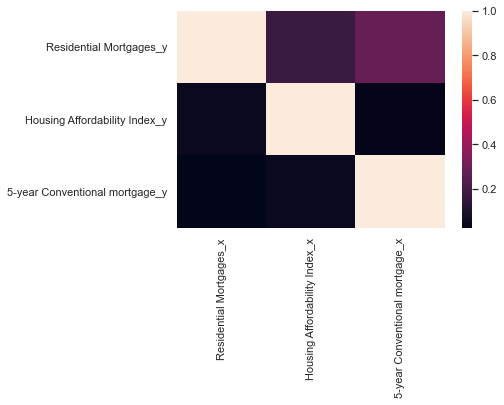

In [58]:
# visualization of grangers causality matrix with heatmap. 
ax = sns.heatmap(df_grangers)

 


In [59]:
#cointegration test
# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df,-1,5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(housing_analysis_combined_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Residential Mortgages ::  23.66     > 24.2761   =>   False
Housing Affordability Index ::  10.71     > 12.3212   =>   False
5-year Conventional mortgage ::  4.61      > 4.1296    =>   True


In [61]:
from statsmodels.tsa.stattools import adfuller
# Store the results of the test in the variable result

In [64]:
#Residential Mortgages ADF
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary



result = adfuller(housing_analysis_combined_df['Residential Mortgages'])
# Access the contents of the results:
print('ADF Statistic: %f' % result[0])
print('p-value:        %f ' % result[1])
print('Lags used:      %d' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print((key, value))

ADF Statistic: 3.125303
p-value:        1.000000 
Lags used:      10
Critical Values:
('1%', -3.4885349695076844)
('5%', -2.887019521656941)
('10%', -2.5803597920604915)


In [65]:
# Housing Affordability Index
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary

result = adfuller(housing_analysis_combined_df['Housing Affordability Index'])
# Access the contents of the results:
print('ADF Statistic: %f' % result[0])
print('p-value:        %f ' % result[1])
print('Lags used:      %d' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print((key, value))

ADF Statistic: -2.565432
p-value:        0.100354 
Lags used:      7
Critical Values:
('1%', -3.4870216863700767)
('5%', -2.8863625166643136)
('10%', -2.580009026141913)


In [66]:
# 5-year Conventional mortgage
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary
result = adfuller(housing_analysis_combined_df['5-year Conventional mortgage'])
# Access the contents of the results:
print('ADF Statistic: %f' % result[0])
print('p-value:        %f ' % result[1])
print('Lags used:      %d' % result[2])
print('Critical Values:')
for key, value in result[4].items():
    print((key, value))

ADF Statistic: -2.431415
p-value:        0.133065 
Lags used:      13
Critical Values:
('1%', -3.4901313156261384)
('5%', -2.8877122815688776)
('10%', -2.5807296460459184)


In [67]:
#1st differencing Residential Mortgages
data_d = housing_analysis_combined_df.diff().dropna()
adfuller_test = adfuller(data_d['Residential Mortgages'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: 0.27827647677122896
p-value: 0.9763255756738312


In [68]:
#1st differencing Housing Affordability Index
data_d = housing_analysis_combined_df.diff().dropna()
adfuller_test = adfuller(data_d['Housing Affordability Index'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -4.654513070321905
p-value: 0.00010236562615111616


In [69]:
#1st differencing 5-year Conventional mortgage
data_d = housing_analysis_combined_df.diff().dropna()
adfuller_test = adfuller(data_d['5-year Conventional mortgage'], autolag= "AIC")
print("ADF test statistic: {}".format(adfuller_test[0]))
print("p-value: {}".format(adfuller_test[1]))

ADF test statistic: -5.388781575498016
p-value: 3.575903785590714e-06
